# Quickstart
* [tutorial](http://lightkurve.keplerscience.org/tutorials/1.02-target-pixel-files.html)

In [1]:
import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np
from astropy.io import fits
import pandas as pd

## How does the Vanderburg & Johnson 2014 K2SFF method work?

* [link](http://lightkurve.keplerscience.org/tutorials/motion-correction/replicate-vanderburg-2014-k2sff.html)

In [2]:
#k2sff lightcurve
vdb_fits = fits.open('hlsp_k2sff_k2_lightcurve_060021426-cet_kepler_v1_llc.fits')

In [3]:
keys = ['MASKTYPE', 'MASKINDE', 'NPIXSAP']
_ = [print(key, ' : ', vdb_fits['BESTAPER'].header[key]) for key in keys]

MASKTYPE  :  PRF FIT
MASKINDE  :  4
NPIXSAP  :  29.0


Mask used in Vanderburg & Johnson (2014):

In [4]:
VDB_J_mask = vdb_fits['PRF_APER_TBL'].data[7,:, :] == True
VDB_J_mask.sum()

53

In [5]:
vdb_fits[2].columns

ColDefs(
    name = 'T'; format = 'D'
    name = 'FRAW'; format = 'D'
    name = 'FCOR'; format = 'D'
    name = 'ARCLENGTH'; format = 'D'
    name = 'MOVING'; format = 'I'
    name = 'CADENCENO'; format = 'J'
)

Diagnostic data

In [6]:
df = pd.read_csv('ep60021426alldiagnostics.csv',index_col=False)
df.head()

,BJD - 2454833,Raw Flux,Corrected Flux,X-centroid,Y-centroid,arclength,Correction,Thrusters On
0,1862.502368,0.995119,0.995985,25.135097,24.661074,2.327480,0.999130,1.0
1,1862.522801,0.997313,0.996767,25.289752,24.418689,1.175322,1.000548,1.0
2,1862.543235,0.996713,0.996136,25.288052,24.429406,1.214627,1.000580,0.0
3,1862.563668,0.996930,0.996277,25.275216,24.448405,1.306617,1.000656,0.0
4,1862.584102,0.996862,0.996228,25.253864,24.480184,1.460259,1.000636,0.0


In [7]:
df.columns

Index(['BJD - 2454833', ' Raw Flux', ' Corrected Flux', ' X-centroid',
       ' Y-centroid', ' arclength', ' Correction', ' Thrusters On'],
      dtype='object')

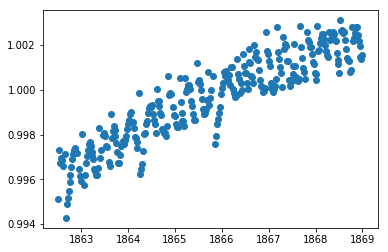

In [8]:
#Vanderburg-provided diagnostic data for the Kepler ENG testing
times = df['BJD - 2454833'].values
fluxes = df[' Raw Flux'].values
xcen = df[' X-centroid'].values
ycen = df[' Y-centroid'].values

pl.plot(times,fluxes,'o')

In [9]:
from scipy.interpolate import BSpline
from scipy import interpolate

def rescale_centroids(col,row):
    col = col - np.mean(col)
    row = row - np.mean(row)
    return col, row

def get_eigen_vectors(centroid_col, centroid_row):
    '''get the eigenvalues and eigenvectors given centroid x, y positions'''
    centroids = np.array([centroid_col, centroid_row])
    eig_val, eig_vec = np.linalg.eigh(np.cov(centroids))
    return eig_val, eig_vec

def rotate(eig_vec, centroid_col, centroid_row):
    """Rotate the coordinate frame of the (col, row) centroids to a new (x,y)
    frame in which the dominant motion of the spacecraft is aligned with
    the x axis.  This makes it easier to fit a characteristic polynomial
    that describes the motion."""
    centroids = np.array([centroid_col, centroid_row])
    return np.dot(eig_vec, centroids)

def fit_curve(rot_rowp, rot_colp, order):
    z = np.polyfit(rot_rowp, rot_colp, order)
    p = np.poly1d(z)
    p_deriv = p.deriv()
    return p,p_deriv

def arclength(x_prime, x_dense, p_deriv):
    """
    Compute the arclength of the polynomial used to fit the centroid
    measurements.

    Parameters
    ----------
    x_prime : float
        Upper limit of the integration domain.
    x_dense : ndarray
        Domain at which the arclength integrand is defined.

    Returns
    -------
    arclength : float
        Result of the arclength integral from x[0] to x1.
    """
        
    s = []
    for i in x_prime:
        gi = x_dense < i
        s_integrand = np.sqrt(1 + p_deriv(x_dense[gi]) ** 2)
        s.append(np.trapz(s_integrand, x=x_dense[gi]))
    return np.array(s)

def find_thruster_events(time,data,Xc,Yc):
    '''
    Find events when the spacecruft thruster are fired. 
    Usually no useful data points are gathered when this happens
    '''

    diff_centroid = np.diff(Xc)**2 + np.diff(Yc)**2

    thruster_mask = diff_centroid < (1.5*np.mean(diff_centroid) + 0.*np.std(diff_centroid))
    
    # this little trick helps us remove 2 data points each time instead of just 1
    thruster_mask1 = np.insert(thruster_mask,0, False) 
    thruster_mask2 = np.append(thruster_mask,False)
    thruster_mask = thruster_mask1*thruster_mask2

    time_thruster = time[ thruster_mask ]
    diff_centroid_thruster = diff_centroid[ thruster_mask[1:] ]
    
#     Xc_clipped = Xc[:][thruster_mask]
#     Yc_clipped = Yc[:][thruster_mask]
#     time_clipped = time[:][thruster_mask]
#     data_clipped = data[:][thruster_mask]

    return ~thruster_mask
    

In [1]:
def apply_sff(times, raw_fluxes, centroid_col, centroid_row, 
        polyorder=5, bins=15, epic=None, showfig=False, return_trend=False):
    """Returns a systematics-corrected LightCurve.

    Note that it is assumed that time and flux do not contain NaNs.

    Parameters
    ----------
    times : array-like
        Time measurements
    raw_fluxes : array-like
        Data flux for every time point
    centroid_col, centroid_row : array-like, array-like
        Centroid column and row coordinates as a function of time
    polyorder : int
        Degree of the polynomial which will be used to fit one
        centroid as a function of the other.
    bins : int
        Number of bins to be used in step (6) to create the
        piece-wise interpolation of arclength vs flux correction.
    windows : int
        Number of windows to subdivide the data.  The SFF algorithm
        is ran independently in each window.
    sigma_1, sigma_2 : float, float
        Sigma values which will be used to reject outliers
        in steps (6) and (2), respectivelly.
            
    Returns
    -------
    corrected_lightcurve : LightCurve object
        Returns a corrected lightcurve object.
    """
        
    col,row = rescale_centroids(centroid_col,centroid_row)
    eig_val, eig_vec = get_eigen_vectors(col, row)
    
    platescale = 4.0 # The Kepler plate scale; has units of arcseconds / pixel
    if showfig:
        v1, v2 = eig_vec
        
        pl.figure()#figsize=(5, 6))
        pl.plot(col * platescale, row * platescale, 'ko', ms=4)
        pl.plot(col * platescale, row * platescale, 'ro', ms=1)
        pl.xticks([-2, -1,0, 1, 2])
        pl.yticks([-2, -1,0, 1, 2])
        pl.xlabel('X position [arcseconds]')
        pl.ylabel('Y position [arcseconds]')
        #pl.xlim(-2, 2)
        #pl.ylim(-2, 2)
        pl.plot([0, v1[0]], [0, v1[1]], color='blue', lw=3)
        pl.plot([0, v2[0]], [0, v2[1]], color='blue', lw=3);
        
    #(1) Rotate the centroid measurements onto the subspace spanned by the
    #eigenvectors of the centroid covariance matrix
    rot_colp, rot_rowp = rotate(eig_vec, col, row) #units in pixels
    
    if showfig:
        pl.figure()#figsize=(5, 6))
        pl.plot(rot_rowp * platescale, rot_colp * platescale, 'ko', ms=4)
        pl.plot(rot_rowp * platescale, rot_colp * platescale, 'ro', ms=1)
        pl.xticks([-2, -1,0, 1, 2])
        pl.yticks([-2, -1,0, 1, 2])
        pl.xlabel("X' position [arcseconds]")
        pl.ylabel("Y' position [arcseconds]")
        #pl.xlim(-2, 2)
        #pl.ylim(-2, 2)
        pl.plot([0, 1], [0, 0], color='blue')
        pl.plot([0, 0], [0, 1], color='blue');
        
    #(2) Fit a polynomial to the rotated centroids
    p, p_deriv = fit_curve(rot_rowp, rot_colp, order=polyorder)
    x_dense = np.linspace(np.min(rot_rowp),  np.max(rot_rowp), 2000)
    
    if showfig:
        pl.figure()
        pl.plot(rot_rowp, rot_colp, '.')
        pl.plot(x_dense, p(x_dense))
        pl.ylabel('Position along minor axis (pixels)')
        pl.xlabel('Position along major axis (pixels)')
        pl.title('Performance of polynomial regression')
#         pl.ylim(-0.1, 0.1);
    
    #(3) Compute the arclength of such polynomial
    N = 1.5 #thruster firing?
    interior_knots = np.arange(times[0]+N, times[0]+6, N)
    #(4) Fit a BSpline of the raw flux as a function of time
    
    t,c,k = interpolate.splrep(times, raw_fluxes, s=0, task=-1, t=interior_knots)
    bspl = BSpline(t,c,k)
    
    if showfig:
        pl.figure()
        pl.plot(times, raw_fluxes, '.', label='raw flux')
        pl.plot(times, bspl(times), label='trend')
        pl.xlabel('$t$ (days)')
        pl.ylabel('Raw Flux');
    
    #Plot the normalized flux versus arclength to see the position-dependent flux
    #(5) Normalize the raw flux by the fitted BSpline computed in step (4)
    fluxes = raw_fluxes/bspl(times)
    
    #Mask the data by keeping only the good samples
    mask = find_thruster_events(times,fluxes,rot_colp,rot_rowp);
    
    clean_fluxes = fluxes[~mask]
    
    al = arclength(rot_rowp[~mask], x_dense, p_deriv) * platescale
    
    sorted_inds = np.argsort(al)
    
    #(6) Bin and interpolate the normalized flux as a function of the arclength
    #interpolate flux versus arclength position in 15 bins of means
    #piecewise linear fit
        
    bins = 15
    knots = np.array([np.min(al)]+
                 [np.median(splt) for splt in np.array_split(al[sorted_inds], bins)]+
                 [np.max(al)])
    
    
    bin_means = np.array([clean_fluxes[sorted_inds][0]]+
                 [np.mean(splt) for splt in np.array_split(clean_fluxes[sorted_inds], 15)]+
                 [clean_fluxes[sorted_inds][-1]])
    
    zz = np.polyfit(al, clean_fluxes, polyorder)
    linfit = np.poly1d(zz)
    #al_dense = np.linspace(0, 4, 1000)
    interp_func = interpolate.interp1d(knots, bin_means)
    
    if showfig:
        pl.figure()#figsize=(5, 6))
        pl.plot(arclength(rot_rowp,x_dense,p_deriv)*platescale, fluxes, 'ko', ms=4)
        pl.plot(arclength(rot_rowp,x_dense,p_deriv)*platescale, fluxes, 'o', color='#3498db', ms=3)
        pl.plot(arclength(rot_rowp[mask],x_dense,p_deriv)*platescale, fluxes[mask], 'o', color='r', ms=3)
        pl.plot(np.sort(al), interp_func(np.sort(al)), '-', color='#e67e22')
        #pl.xticks([0, 1, 2, 3, 4])
        
        pl.minorticks_on()
        pl.xlabel('Arclength [arcseconds]')
        pl.ylabel('Relative Brightness')
        pl.title(epic)
#         pl.xlim(0,4)
#         pl.ylim(0.997, 1.002);
        
    #(7) Divide the raw flux by the piecewise linear interpolation done in step (6)
    corr_fluxes = clean_fluxes / interp_func(al)
    
    #(8) Set raw flux as the flux computed in step (7) and repeat
   
    if showfig:
        pl.figure(figsize=(10,6))
        dy = 0.004
        pl.plot(times, raw_fluxes+dy, 'ko', ms=4)
        pl.plot(times, raw_fluxes+dy, 'o', color='#3498db', ms=3)
        pl.plot(times[mask], raw_fluxes[mask]+dy, 'o', color='r', ms=3)
        pl.plot(times[~mask], corr_fluxes*bspl(times[~mask]), 'o', color='k', ms = 4)
        pl.plot(times[~mask], corr_fluxes*bspl(times[~mask]), 'o', color='#e67e22', ms = 3)

        pl.xlabel('BJD - 2454833')
        pl.ylabel('Relative Brightness')

#         pl.xlim(1862, 1870)
#         pl.ylim(0.994, 1.008);

    if return_trend:
        return corr_fluxes, bspl(times[~mask])
    #(9) Multiply back the fitted BSpline
    else:
        return corr_fluxes*bspl(times[~mask])

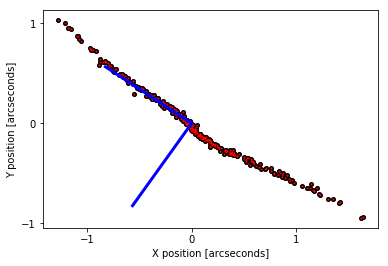

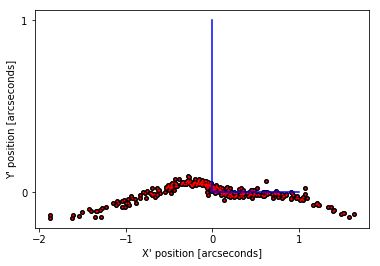

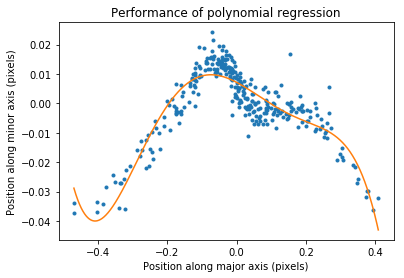

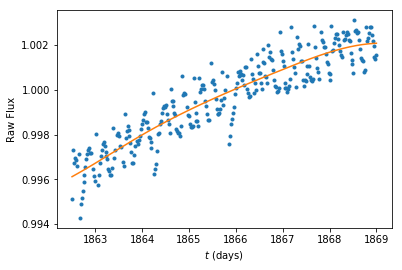

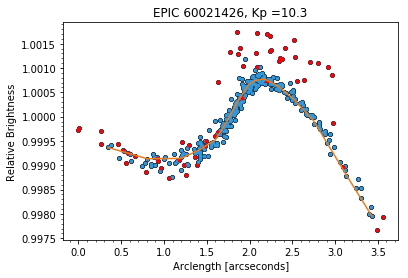

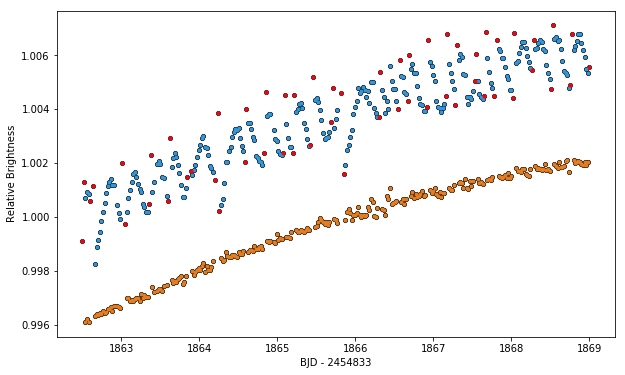

In [11]:
corr_fluxes, trend = apply_sff(times, fluxes, ycen, xcen, showfig=True, return_trend=True)

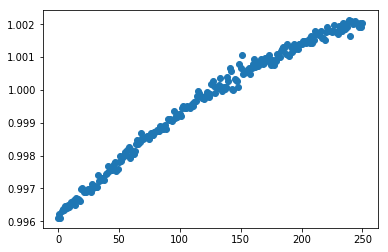

In [13]:
pl.plot(corr_fluxes,'o')

In [14]:
corr_fluxes, trend = sff(times, fluxes, ycen, xcen, return_trend=True, showfig=False)

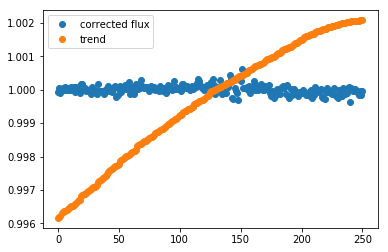

In [15]:
pl.plot(corr_fluxes,'o',label='corrected flux')
pl.plot(trend,'o',label='trend')
pl.legend()

## Using custom aperture

In [18]:
from matplotlib.colors import LogNorm
from scipy.ndimage import measurements
import os

cmap='viridis'

def make_aperture_outline(frame, no_combined_images=1, threshold=0.5):
    ## this is a little module that defines so called outlines to be used for plotting apertures

    thres_val = no_combined_images * threshold
    mapimg = (frame > thres_val)
    ver_seg = np.where(mapimg[:,1:] != mapimg[:,:-1])
    hor_seg = np.where(mapimg[1:,:] != mapimg[:-1,:])

    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))

    # and the same for vertical segments
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))


    segments = np.array(l)

    x0 = -0.5
    x1 = frame.shape[1]+x0
    y0 = -0.5
    y1 = frame.shape[0]+y0

    #   now we need to know something about the image which is shown
    #   at this point let's assume it has extents (x0, y0)..(x1,y1) on the axis
    #   drawn with origin='lower'
    # with this information we can rescale our points
    segments[:,0] = x0 + (x1-x0) * segments[:,0] / mapimg.shape[1]
    segments[:,1] = y0 + (y1-y0) * segments[:,1] / mapimg.shape[0]

    return segments

def find_aperture(dates,fluxes,starname='',kepmag='na',cutoff_limit=1.,showfig=None):
    #
    # This definition reads a 2D array of fluxes (over time) and creates an aperture mask which can later be used to select those pixels for inclusion in light curve
    #

    # first sum all the flux over the different times, this assumes limited movement throughout the time series
    flux = np.nansum(fluxes,axis=0)

    # define which cutoff flux to use for including pixel in mask
    cutoff = cutoff_limit*np.median(flux) # perhaps a more elaborate way to define this could be found in the future but this seems to work pretty well.

    # define the aperture based on cutoff and make it into array of 1 and 0
    aperture =  np.array([flux > cutoff]) #scipy.zeros((np.shape(flux)[0],np.shape(flux)[1]), int)
    aperture = np.array(1*aperture)
    #print aperture
    outline_all = make_aperture_outline(aperture[0]) # an outline (ONLY for figure) of what we are including if we would make no breakups

    # this cool little trick allows us to measure distinct blocks of apertures, and only select the biggest one
    lw, num = measurements.label(aperture) # this numbers the different apertures distinctly
    area = measurements.sum(aperture, lw, index=np.arange(lw.max() + 1)) # this measures the size of the apertures
    aperture = area[lw].astype(int) # this replaces the 1s by the size of the aperture
    aperture = (aperture >= np.max(aperture))*1 # remake into 0s and 1s but only keep the largest aperture

    outline = make_aperture_outline(aperture[0]) # a new outline (ONLY for figure)

    if showfig: # make aperture figure
        pl.figure('Aperture_' + str(starname))
        pl.imshow(flux,norm=LogNorm(),interpolation="none",cmap=cmap)
        pl.plot(outline_all[:, 0], outline_all[:, 1],color='green', zorder=10, lw=2.5)
        pl.plot(outline[:, 0], outline[:, 1],color='red', zorder=10, lw=2.5)#,label=str(kepmag))
        pl.colorbar(orientation='vertical')
        pl.xlabel('X',fontsize=15)
        pl.ylabel('Y',fontsize=15)
        #pl.legend()
        pl.tight_layout()
        pl.show()
    return np.array(aperture[0],dtype=bool)

import warnings
def get_centroids(flux, column, row, aperture_mask):
    """Returns centroids based on sample moments.

    Parameters
    ----------
    aperture_mask : array-like
        A boolean array describing the aperture such that `False` means
        that the pixel will be masked out.

    Returns
    -------
    col_centr, row_centr : tuple
        Arrays containing centroids for column and row at each cadence
    """
    yy, xx = np.indices(flux.shape[1:]) + 0.5
    yy = row + yy
    xx = column + xx
    total_flux = np.nansum(flux[:, aperture_mask], axis=1)
    with warnings.catch_warnings():
        # RuntimeWarnings may occur below if total_flux contains zeros
        warnings.simplefilter("ignore", RuntimeWarning)
        col_centr = np.nansum(xx * aperture_mask * flux, axis=(1, 2)) / total_flux
        row_centr = np.nansum(yy * aperture_mask * flux, axis=(1, 2)) / total_flux

    return col_centr, row_centr

In [19]:
#official = '2014044044430.fits'
official = 'https://archive.stsci.edu/pub/k2/eng/long_cadence/kplr060021426-2014044044430_lpd-targ.fits'

header = fits.open(official)[1].header 
recarray = fits.open(official)[1].data

recarray.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '2500J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(50,50)'
    name = 'FLUX'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50,50)'
    name = 'FLUX_ERR'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50,50)'
    name = 'FLUX_BKG'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50,50)'
    name = 'FLUX_BKG_ERR'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50,50)'
    name = 'COSMIC_RAYS'; format = '2500E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(50,50)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
)

In [20]:
times    = recarray['TIME']
fluxes   = recarray['FLUX']
flux_errs= recarray['FLUX_ERR']
raw_fluxes= recarray['RAW_CNTS']
pos_corr1 = recarray['POS_CORR1']
pos_corr2 = recarray['POS_CORR2']

fluxes.shape

(440, 50, 50)

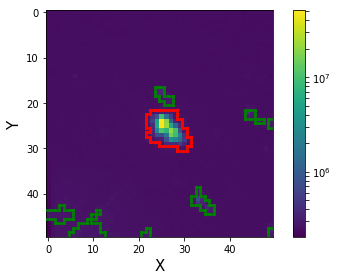

In [21]:
cutoff_limit = 1.1
aperture = find_aperture(times,fluxes,cutoff_limit=cutoff_limit,showfig=True);

In [22]:
from lightkurve import KeplerTargetPixelFile

tpf = KeplerTargetPixelFile(official, quality_bitmask='hardest')

lc = tpf.to_lightcurve(aperture_mask=aperture)
flux = lc.flux
time = lc.time
cent_col = lc.centroid_col
cent_row = lc.centroid_row

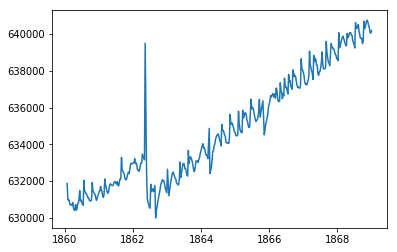

In [23]:
pl.plot(time,flux)

In [24]:
len(flux)

423

In [25]:
len(cent_col)

423

In [26]:
len(flux)

423

In [28]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
from astropy.stats import sigma_clip
from scipy import linalg, interpolate
import warnings

def correct(time, flux, centroid_col, centroid_row,
            polyorder=5, niters=3, bins=15, windows=1, sigma_1=3.,
            sigma_2=5., restore_trend=False):
    """Returns a systematics-corrected LightCurve.

    Note that it is assumed that time and flux do not contain NaNs.

    Parameters
    ----------
    time : array-like
        Time measurements
    flux : array-like
        Data flux for every time point
    centroid_col, centroid_row : array-like, array-like
        Centroid column and row coordinates as a function of time
    polyorder : int
        Degree of the polynomial which will be used to fit one
        centroid as a function of the other.
    niters : int
        Number of iterations of the aforementioned algorithm.
    bins : int
        Number of bins to be used in step (6) to create the
        piece-wise interpolation of arclength vs flux correction.
    windows : int
        Number of windows to subdivide the data.  The SFF algorithm
        is ran independently in each window.
    sigma_1, sigma_2 : float, float
        Sigma values which will be used to reject outliers
        in steps (6) and (2), respectivelly.
    restore_trend : bool
        If `True`, the long-term trend will be added back into the
        lightcurve.

    Returns
    -------
    corrected_lightcurve : LightCurve object
        Returns a corrected lightcurve object.
    """
    timecopy = time
    time = np.array_split(time, windows)
    flux = np.array_split(flux, windows)
    centroid_col = np.array_split(centroid_col, windows)
    centroid_row = np.array_split(centroid_row, windows)

    flux_hat = np.array([])
    # The SFF algorithm is going to be run on each window independently

    for i in range(windows):
        # To make it easier (and more numerically stable) to fit a
        # characteristic polynomial that describes the spacecraft motion,
        # we rotate the centroids to a new coordinate frame in which
        # the dominant direction of motion is aligned with the x-axis.
        rot_col, rot_row = rotate_centroids(centroid_col[i],centroid_row[i])
        # Next, we fit the motion polynomial after removing outliers
        outlier_cent = sigma_clip(data=rot_col,
                                       sigma=sigma_2).mask
        with warnings.catch_warnings():
            # ignore warning messages related to polyfit being poorly conditioned
            warnings.simplefilter("ignore", category=np.RankWarning)
            coeffs = np.polyfit(rot_row[~outlier_cent],
                                rot_col[~outlier_cent], polyorder)

        poly = np.poly1d(coeffs)
        polyprime = np.poly1d(coeffs).deriv()

        # Compute the arclength s.  It is the length of the polynomial
        # (fitted above) that describes the typical motion.
        x = np.linspace(np.min(rot_row[~outlier_cent]),
                        np.max(rot_row[~outlier_cent]), 10000)
        s = np.array([arclength(x1=xp, x=x, polyprime=polyprime) for xp in rot_row])

        # Next, we find and apply the correction iteratively
        trend = np.ones(len(time[i]))
        for n in range(niters):
            # First, fit a spline to capture the long-term varation
            # We don't want to fit the long-term trend because we know
            # that the K2 motion noise is a high-frequency effect.
            bspline = fit_bspline(time[i], flux[i])
            # Remove the long-term variation by dividing the flux by the spline
            iter_trend = bspline(time[i] - time[i][0])
            normflux = flux[i] / iter_trend
            trend *= iter_trend
            # Bin and interpolate normalized flux to capture the dependency
            # of the flux as a function of arclength
            interp = bin_and_interpolate(s, normflux, bins,
                                        sigma_1,
                                        outlier_cent)
            # Correct the raw flux
            corrected_flux = normflux / interp(s)
            flux[i] = corrected_flux

        if restore_trend:
            flux[i] *= trend
        flux_hat = np.append(flux_hat, flux[i])

    return LightCurve(time=timecopy, flux=flux_hat)

def rotate_centroids(centroid_col, centroid_row):
    """Rotate the coordinate frame of the (col, row) centroids to a new (x,y)
    frame in which the dominant motion of the spacecraft is aligned with
    the x axis.  This makes it easier to fit a characteristic polynomial
    that describes the motion."""
    centroids = np.array([centroid_col, centroid_row])
    _, eig_vecs = linalg.eigh(np.cov(centroids))
    return np.dot(eig_vecs, centroids)

def _plot_rotated_centroids(rot_row, rot_col, outlier_cent):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(rot_row[~outlier_cent], rot_col[~outlier_cent],
            'ko', markersize=3)
    ax.plot(rot_row[~outlier_cent], rot_col[~outlier_cent],
            'bo', markersize=2)
    ax.plot(rot_row[outlier_cent], rot_col[outlier_cent],
            'ko', markersize=3)
    ax.plot(rot_row[outlier_cent], rot_col[outlier_cent],
            'ro', markersize=2)
    x = np.linspace(min(rot_row), max(rot_row), 200)
    ax.plot(x, poly(x), '--')
    plt.xlabel("Rotated row centroid")
    plt.ylabel("Rotated column centroid")
    return ax
    
def arclength(x1, x, polyprime):
        """Compute the arclength of the polynomial used to fit the centroid
        measurements.

        Parameters
        ----------
        x1 : float
            Upper limit of the integration domain.
        x : ndarray
            Domain at which the arclength integrand is defined.

        Returns
        -------
        arclength : float
            Result of the arclength integral from x[0] to x1.
        """
        mask = x < x1
        return np.trapz(y=np.sqrt(1 + polyprime(x[mask]) ** 2), x=x[mask])
    
def fit_bspline(time, flux, s=0):
        """s describes the "smoothness" of the spline"""
        time = time - time[0]
        knots = np.arange(0, time[-1], 1.5)
        try:
            t, c, k = interpolate.splrep(time, flux, t=knots[1:], s=s, task=-1)
        except:
            #sort time
            #df = self._sort_vectors(time,flux)
            df = pd.DataFrame(flux,index=time)
            df.columns = ['flux']

            df = df.sort_index()
            time = df.index.values
            flux = df.flux.values
            t, c, k = interpolate.splrep(time, flux, t=knots[1:], s=s, task=-1)

        return interpolate.BSpline(t, c, k)
    
def bin_and_interpolate(s, normflux, bins, sigma, outlier_mask):
    idx = np.argsort(s)
    s_srtd = s[idx]
    normflux_srtd = normflux[idx]

    outlier_mask = sigma_clip(data=normflux_srtd, sigma=sigma).mask
    normflux_srtd = normflux_srtd[~outlier_mask]
    s_srtd = s_srtd[~outlier_mask]

    knots = np.array([np.min(s_srtd)]
                     + [np.median(split) for split in np.array_split(s_srtd, bins)]
                     + [np.max(s_srtd)])
    bin_means = np.array([normflux_srtd[0]]
                         + [np.mean(split) for split in np.array_split(normflux_srtd, bins)]
                         + [normflux_srtd[-1]])
    return interpolate.interp1d(knots, bin_means, bounds_error=False,
                                fill_value='extrapolate')

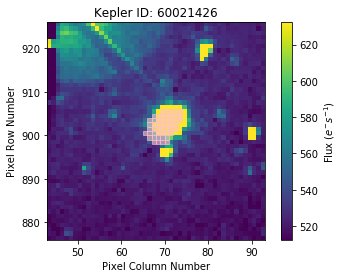

In [117]:
from lightkurve import KeplerTargetPixelFile

sigma = 3

#read tpf
tpf = KeplerTargetPixelFile(official, quality_bitmask='hardest')
#confirm aperture
times, fluxes = tpf.time, tpf.flux
aperture = find_aperture(times,fluxes,cutoff_limit=cutoff_limit,starname=tpf.keplerid)
tpf.plot(aperture_mask=aperture)

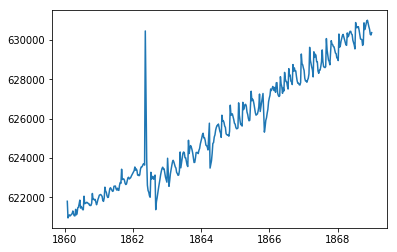

In [118]:
#convert to lightcurve
lc = tpf.to_lightcurve(aperture_mask=aperture);
#clean 
lc = lc.remove_nans().remove_outliers(sigma=3);
time, flux = lc.time, lc.flux

pl.plot(time,flux)